In [1]:
import pandas as pd
import scipy.stats as stats

In [2]:
order_data = pd.read_csv('data/orders.csv')
browser_data = pd.read_csv('data/browsing.csv')

### Our Plan of Action

- Remove personal identifiers with the exception of the user ID, which is hashed so that if marketing team comes back with specific questions, we can try to help answer them
- If the user session came in with a tagged campaign, retain campaign information; otherwise leave blank
- Retain billing city and state, as this was specifically asked for by the marketing department to effectively answer questions for their campaigns
- Join order data and aggregate order quantity (number of orders) and order value (sum of quantities) per user
- Bound outliers that have exceptionally large or small amounts of customer value (if needed, you can create a written summary of these for marketing review)

In [3]:
order_data.head()

,order_number,user_id,email,street_address,city,state,num_items,total_price,timestamp
0,754,roy50,margaretwalker@example.com,8222 Jared Plains Suite 489,Millerfurt,Delaware,4,162,2022-07-31T13:53:42.176704
1,371,handerson,james63@example.org,39972 Isabella Haven Suite 670,Farrellport,Oklahoma,3,42,2022-08-03T17:54:12.176704
2,376,william55,sotopatricia@example.net,4418 Raymond Club,West Andreafort,Illinois,8,198,2022-08-05T18:54:45.176704
3,431,uking,cponce@example.com,369 Angela Green Suite 649,Whitemouth,Tennessee,6,90,2022-08-06T20:55:01.176704
4,713,tiffany94,kingelizabeth@example.net,3030 Kerr Streets Apt. 695,Hamptonhaven,Indiana,5,62,2022-08-09T22:55:50.176704


In [4]:
browser_data.head()

,order_number,inbound_uri,browser_agent,ip,timestamp
0,9,weight-likely,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_8; ...,199.252.41.214,2022-07-31T13:53:49.548290
1,441,position-report,Opera/9.44.(X11; Linux x86_64; gv-GB) Presto/2...,179.25.93.144,2022-08-03T17:54:25.548290
2,72,tough-age-growth,Mozilla/5.0 (Windows; U; Windows NT 5.0) Apple...,125.124.68.154,2022-08-05T18:55:27.548290
3,168,way-right-century,Mozilla/5.0 (compatible; MSIE 6.0; Windows 98;...,22.43.48.185,2022-08-08T20:55:59.548290
4,539,event-might-society,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...,30.219.140.88,2022-08-10T23:57:01.548290


### First we drop the unnecessary PII columns

In [5]:
browser_data = browser_data.drop(['browser_agent', 'ip'], axis=1)

In [6]:
order_data = order_data.drop(['email', 'street_address'], axis=1)

In [7]:
browser_and_orders = browser_data.merge(order_data, how='inner', on=['order_number'], 
                                        suffixes=('__browser','__order'))

In [8]:
browser_and_orders.head()

,order_number,inbound_uri,timestamp__browser,user_id,city,state,num_items,total_price,timestamp__order
0,9,weight-likely,2022-07-31T13:53:49.548290,qgeorge,New Beth,Virginia,2,198,2024-02-17T09:17:44.176704
1,9,weight-likely,2022-07-31T13:53:49.548290,ilarsen,West Drewfort,Texas,4,162,2030-02-05T06:27:23.176704
2,9,weight-likely,2022-07-31T13:53:49.548290,kelliott,Conniemouth,Georgia,3,106,2035-02-11T03:07:40.176704
3,9,weight-likely,2022-07-31T13:53:49.548290,angela76,Brownville,South Dakota,6,22,2043-03-24T10:33:55.176704
4,9,weight-likely,2022-07-31T13:53:49.548290,adrianhughes,Murphyhaven,Arizona,3,30,2058-07-13T21:12:02.176704


In [9]:
summary_by_order = browser_and_orders.groupby('order_number').agg({'user_id':'first', 
                                                'city':'first', 
                                                'state':'first', 
                                                'num_items':'sum',
                                                'total_price': 'sum',
                                                'timestamp__order': 'first',
                                                'inbound_uri': 'first'})

In [10]:
summary_by_order.head()

,user_id,city,state,num_items,total_price,timestamp__order,inbound_uri
order_number,,,,,,,
0,aaron21,Walkerville,Delaware,605,9108,2045-06-23T14:05:41.176704,bag-fast-difficult
1,jessicajacobs,North Adam,Georgia,252,4860,2025-10-06T02:48:18.176704,those-color-degree
2,rcombs,West Jaredberg,Mississippi,305,4750,2046-11-03T19:15:02.176704,third-wish-spring
3,brandon98,Ryanchester,Alaska,440,6402,2038-10-10T12:43:40.176704,produce-might-a
4,desireegonzales,Thomasshire,Arizona,680,13420,2033-05-02T14:28:03.176704,whole-activity-new


### Encrypting the User ID

In [11]:
summary_by_order.user_id.map(lambda x: len(x)).max()

19

In [12]:
import string, random

def genkey(length: int):
    """Generate key."""
    return "".join(random.choice(string.ascii_lowercase + 
                                 string.ascii_uppercase + 
                                 string.digits + 
                                 '[@_!#$%^&*()<>?/\|}{~:]') for _ in range(length))

def xor_strings(s, t):
    """xor two strings together."""
    if isinstance(s, str):
        # Text strings contain single characters
        return "".join(chr(ord(a) ^ ord(b)) for a, b in zip(s, t))
    else:
        # Bytes objects contain integer values in the range 0-255
        return bytes([a ^ b for a, b in zip(s, t)])

In [13]:
my_secret_key = genkey(20)

In [14]:
def xor_username(key, string):
    if len(string) < 20:
        string += ' ' * (20 - len(string))
    return xor_strings(string, key)

In [15]:
summary_by_order['e_user_id'] = summary_by_order.user_id.map(lambda x: xor_username(my_secret_key, x))

In [16]:
summary_by_order = summary_by_order.drop(['user_id'], axis=1)

In [17]:
xor_username(my_secret_key, summary_by_order['e_user_id'][1])

'jessicajacobs       '

### Key Safety

What happens if we change or lose the key? :/ 

In [18]:
backup = my_secret_key

In [19]:
my_secret_key = genkey(20)

In [20]:
xor_username(my_secret_key, summary_by_order['e_user_id'][1])

'nX@_4{rwiiOqM\x1d\x0c\r?.;@'

### Finding Bounds and Outliers

<Axes: >

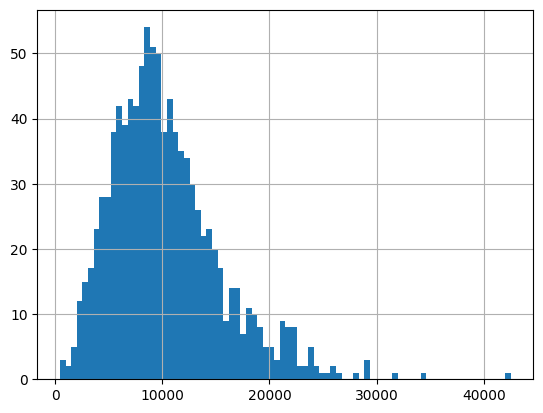

In [21]:
summary_by_order.total_price.hist(bins=80)

<Axes: >

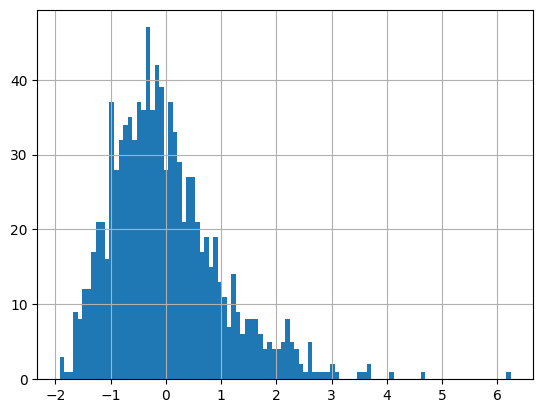

In [22]:
summary_by_order['z-score'] = stats.zscore(list(summary_by_order.total_price))

summary_by_order['z-score'].hist(bins=100)

In [23]:
summary_by_order[summary_by_order.total_price > 27000].count()

city                7
state               7
num_items           7
total_price         7
timestamp__order    7
inbound_uri         7
e_user_id           7
z-score             7
dtype: int64

In [24]:
summary_by_order[summary_by_order.total_price < 1500].count()

city                5
state               5
num_items           5
total_price         5
timestamp__order    5
inbound_uri         5
e_user_id           5
z-score             5
dtype: int64

In [25]:
def remove_order_outliers(total):
    if total > 27000 or total < 1500:
        # NOTE: we want to watch this over time if we rerun the report and make sure it is fitting.
        # We could also normalize the data and use Interquartile Range (IQR) or Z-Scores 
        return True
    return False

In [26]:
summary_by_order['remove'] = summary_by_order.total_price.map(remove_order_outliers)

In [27]:
summary_by_order.count()

city                1000
state               1000
num_items           1000
total_price         1000
timestamp__order    1000
inbound_uri         1000
e_user_id           1000
z-score             1000
remove              1000
dtype: int64

In [28]:
summary_by_order = summary_by_order[summary_by_order['remove'] == False]

In [29]:
summary_by_order = summary_by_order.drop(['remove'], axis=1)

### Getting started with Great Expectations

In [30]:
import great_expectations as ge
context = ge.get_context()

In [31]:
ge_df = ge.from_pandas(summary_by_order)

In [32]:
ge_df.expect_column_values_to_be_between('total_price', 1500, 27000)

{
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "meta": {},
  "result": {
    "element_count": 988,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "success": true
}

In [33]:
ge_df.get_expectation_suite(discard_failed_expectations=False)


{
  "expectation_suite_name": "default",
  "meta": {
    "great_expectations_version": "0.15.49"
  },
  "data_asset_type": "Dataset",
  "ge_cloud_id": null,
  "expectations": [
    {
      "meta": {},
      "expectation_type": "expect_column_values_to_be_between",
      "kwargs": {
        "column": "total_price",
        "min_value": 1500,
        "max_value": 27000
      }
    }
  ]
}

In [34]:
import json
with open("order_summary_for_sharing_expecation_file.json", "w") as my_file:    
    my_file.write(        
        json.dumps(ge_df.get_expectation_suite().to_json_dict())
    )

In [36]:
summary_by_order

,city,state,num_items,total_price,timestamp__order,inbound_uri,e_user_id,z-score
order_number,,,,,,,,
0,Walkerville,Delaware,605,9108,2045-06-23T14:05:41.176704,bag-fast-difficult,] [konEyONmNFSFc,-0.238824
1,North Adam,Georgia,252,4860,2025-10-06T02:48:18.176704,those-color-degree,V\t\:?$:  >NFSFc,-1.063402
2,West Jaredberg,Mississippi,305,4750,2046-11-03T19:15:02.176704,third-wish-spring,N W*~nEyONmNFSFc,-1.084755
3,Ryanchester,Alaska,440,6402,2038-10-10T12:43:40.176704,produce-might-a,^Q60w]yONmNFSFc,-0.764085
4,Thomasshire,Arizona,680,13420,2033-05-02T14:28:03.176704,whole-activity-new,X\t G<;)\n7! SFc,0.598178
...,...,...,...,...,...,...,...,...
995,Ryanland,Idaho,161,6986,2029-02-28T09:00:44.176704,affect-coach,] `~nEyONmNFSFc,-0.650725
996,Jeremymouth,California,528,7896,2040-09-11T21:51:02.176704,film-and-nature,QL:6/5 9 FSFc,-0.474085
997,West Kennethtown,New Hampshire,1008,22144,2023-03-19T16:55:31.176704,if-follow-large,_ Ay~nEyONmNFSFc,2.291592


In [37]:
summary_by_order.to_csv('data/order_summary_for_sharing.csv', escapechar='\\')

### Challenges

- Document the above pipeline and its privacy constraints in a text and graphic form, as if you would share it with fellow stakeholders. What is important for them to know? How can you communicate it to them concisely?
- How would you test to ensure that differential privacy mechanism was used? How could you validate and audit pipelines that use anonymization?